In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import json

In [2]:
def approx_eq(a, b):
    return abs(a - b) < .0001

In [3]:
class EulerCauchy:
    def __init__(self, coefficients=np.zeros(3)):
        self.coefficients = coefficients
    
    def m(self): # homogenous solution:
        m_poly = np.poly1d(0)
        for i, coefficient in enumerate(self.coefficients):
            poly = 1
            for i in range(0,len(self.coefficients)-1-i):
                poly *= np.poly1d([1,-i])
            m_poly += poly * coefficient
        return np.roots(m_poly)
        
    def roots(self):
        roots = {} # elements in form of {"m":i} where i is the number of repetitions of the root
        m_vals = self.m()
        for m_val in m_vals:
            matches = [root for root in roots.keys() if approx_eq(root, m_val) or approx_eq(root, np.conjugate(m_val))]
            if matches:
                roots[matches[0]] += 1
            else:
                roots[m_val] = 1
        return roots

    def y(self, x):
        y = 0
        i = 0
        roots = self.roots()
        for root in roots.keys():
            if root.imag:
                for n_rep in range(0, roots[root], 2):
                    y += (math.log(x) ** n_rep) * (x ** root.real) * (self.constants[i] * math.cos(root.imag * math.log(x)) 
                                                                      + self.constants[i+1] * math.sin(root.imag * math.log(x)))
                i += 2
            else:
                for n_rep in range(roots[root]):
                    y += self.constants[i] * (math.log(x) ** n_rep) * (x ** root)
                i += 1
        return float(y)

class ConstantCoefficients:
    def __init__(self, coefficients=np.zeros(3)):
        self.coefficients = coefficients

    def lbda(self):
        return np.roots(self.coefficients)
        
    def roots(self):
        roots = {} # elements in form of {"m":i} where i is the number of repetitions of the root
        lbda_vals = self.lbda()
        for lbda_val in lbda_vals:
            matches = [root for root in roots.keys() if approx_eq(root, lbda_val) or approx_eq(root, np.conjugate(lbda_val))]
            if matches:
                roots[matches[0]] += 1
            else:
                roots[lbda_val] = 1
        return roots
    
    def y(self, x):
        y = 0
        i = 0
        roots = self.roots()
        for root in roots.keys():
            if root.imag:
                for n_rep in range(0, roots[root], 2):
                    y += (x ** n_rep) * (math.e ** (root.real * x)) * (self.constants[i] * math.cos(root.imag * x) 
                                                                      + self.constants[i+1] * math.sin(root.imag * x))
                i += 2
            else:
                for n_rep in range(roots[root]):
                    y += self.constants[i] * (x ** n_rep) * (math.e ** (root.real * x))
                i += 1
        return float(y)

In [4]:
def normalize(values):
    return values - np.min(values) / (np.max(values) - np.min(values)) * 255

def valuemap(i, coefficients, untruncated_constants):
    eq = EulerCauchy(coefficients) if i else ConstantCoefficients(coefficients)
    eq.constants = untruncated_constants
    return np.array(list(map(eq.y, np.arange(1,226))))

In [5]:
from PIL import Image
image = np.asarray(Image.open('test.png'), dtype=float)[:,:,0]

In [6]:
def generate_image(x_constants, y_constants):
    x_values = sum(valuemap(x_constant['type'], x_constant['coefficients'], x_constant['constants']) for x_constant in x_constants)
    y_values = sum(valuemap(y_constant['type'], y_constant['coefficients'], y_constant['constants']) for y_constant in y_constants)
    x_values = (x_values - np.min(x_values)) / (np.max(x_values) - np.min(x_values)) * 255
    y_values = (y_values - np.min(y_values)) / (np.max(y_values) - np.min(y_values)) * 255
    x_values = np.repeat(x_values[:,np.newaxis], 225, axis=1).T
    y_values = np.repeat(y_values[np.newaxis,:], 225, axis=0).T
    return (x_values + y_values) / 2

In [7]:
def flatten(xss):
    return [x for xs in xss for x in xs]

[[178.97972885 182.28737113 184.26131001 ... 250.34156679 250.55501612
  250.76849779]
 [184.26751046 187.48188645 189.40169598 ... 254.14891724 254.3591716
  254.56946313]
 [184.86185072 188.06606868 189.97997495 ... 254.58016533 254.79006381
  255.        ]
 ...
 [ 41.68213778  54.15111214  60.46393669 ... 179.92931205 180.22617283
  180.52284276]
 [ 41.22233643  53.79798655  60.14788484 ... 179.8233515  180.12038692
  180.4172308 ]
 [ 40.76032203  53.44479571  59.83218935 ... 179.71800293 180.01521218
  180.3122292 ]]


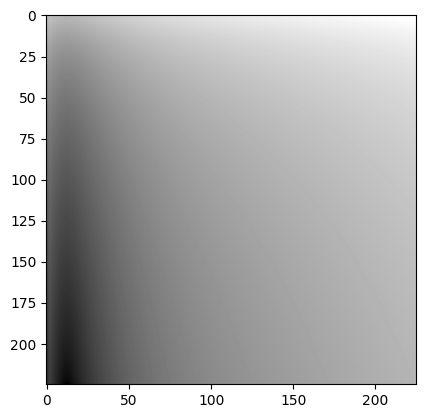

In [8]:
x_constants = [
    {
        'type': 1,
        'coefficients': np.random.rand(3) * 10,
        'constants': np.random.rand(3),
    } for _ in range(20)
]
y_constants = [
    {
        'type': 1,
        'coefficients': np.random.rand(3) * 10,
        'constants': np.random.rand(3),
    } for _ in range(20)
]

generated_image = (generate_image(x_constants,y_constants) * 255) ** (1/2)
print(generated_image)
plt.imshow(generated_image, cmap='gray')

In [ ]:
accuracies = {}

while True:
    x_constants = [
        {
            'type': 1,
            'coefficients': np.random.rand(3),
            'constants': np.random.rand(3),
        } for _ in range(5)
    ]
    y_constants = [
        {
            'type': 1,
            'coefficients': np.random.rand(3),
            'constants': np.random.rand(3),
        } for _ in range(5)
    ]

    generated_image = generate_image(x_constants,y_constants)
    accuracy = np.sum(abs(image - generated_image) < 10) / image.size

    accuracies[accuracy] = (x_constants, y_constants)
    accuracies = dict(sorted(accuracies.items(), reverse=True))
    plt.imsave('output.jpeg', generated_image, cmap='gray')
    print(list(accuracies.keys())[0])
    
    # combined_x_constants = flatten([constant[0] for constant in lowest_mse.values()])
    # combined_y_constants = flatten([constant[1] for constant in lowest_mse.values()])
    # combined_image = generate_image(combined_x_constants, combined_y_constants)
    # combined_mse = np.sum((combined_image-image) ** 2)

    # if combined_mse in lowest_mse.keys():
    #     continue

    # for key in lowest_mse.keys():
    #     if combined_mse < key:
    #         lowest_mse.popitem()
    #         lowest_mse[combined_mse] = (combined_x_constants, combined_y_constants)
    #         lowest_mse = dict(sorted(lowest_mse.items()))
    #         print(lowest_mse.keys())
    #         break

0.02500740740740741
0.02500740740740741
0.033204938271604936
0.033204938271604936
0.033204938271604936
0.04331851851851852
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222
0.04462222222222222


KeyboardInterrupt: 

42.93544752674601


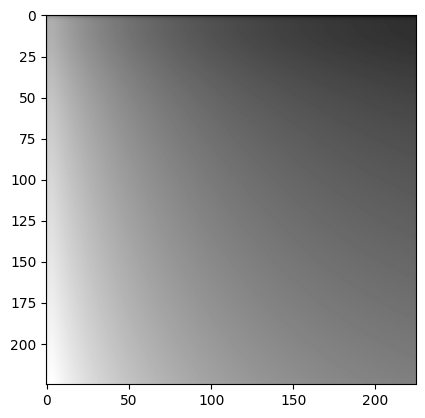

In [ ]:
eq = list(accuracies.values())[0]
print(np.std(generate_image(eq[0], eq[1])))
plt.imshow(generate_image(eq[0], eq[1]), cmap='gray')

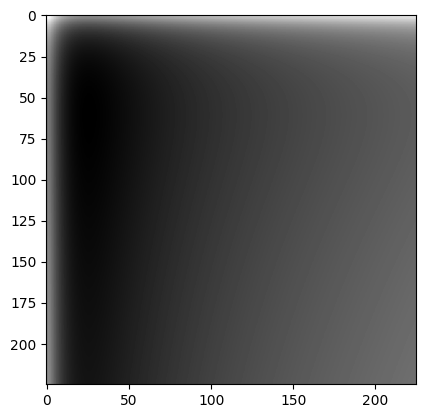

In [ ]:
random_images = list(accuracies.values())[0:50]
# combined_x_constants = flatten([constant[0] for constant in lowest_mse.values()])
# combined_y_constants = flatten([constant[1] for constant in lowest_mse.values()])
combined_image = np.zeros((225,225))
for im in random_images:
    combined_image += generate_image(im[0], im[1])
combined_image /= len(random_images)
combined_mse = np.sum((combined_image-image) ** 2)
plt.imshow(combined_image, cmap='gray')

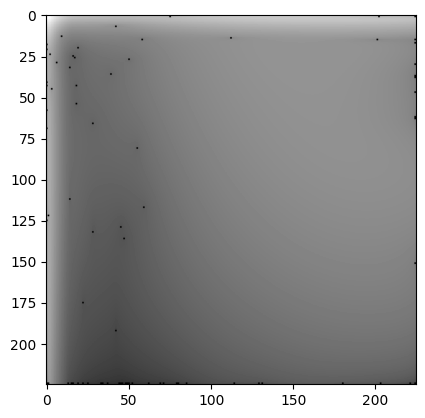

In [ ]:
random_images = list(accuracies.values())[0:5]
# combined_x_constants = flatten([constant[0] for constant in lowest_mse.values()])
# combined_y_constants = flatten([constant[1] for constant in lowest_mse.values()])
combined_image = np.ones((225,225))
for im in random_images:
    combined_image *= generate_image(im[0], im[1])
combined_image **= (1/len(random_images))
combined_mse = np.sum((combined_image-image) ** 2)
plt.imshow(combined_image, cmap='gray')